In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import copy
from grid import Grid
import math
import random

In [54]:
def track_policy_iteration(Grid):
    U = [[0 for _ in range(Grid.size)] for _ in range(Grid.size)]
    policy = {}
    for i in range(Grid.size):
        for j in range(Grid.size):
            if (i, j) not in Grid.walls:
                policy[(i, j)] = random.choice(Grid.actions)
    unchanged = False
    iteration = 0
    all_states = []
    for row in range(Grid.size):
        for col in range(Grid.size):
            if (row, col) not in Grid.walls:
                all_states.append((row, col))
    utilities_history = {state: [] for state in all_states}
    for state in all_states:
            row, col = state
            utilities_history[state].append(U[row][col])
    while not unchanged:
        U = track_policy_evaluation(Grid, policy)
        for state in all_states:
            row, col = state
            utilities_history[state].append(U[row][col])
        unchanged = True
        for i in range(Grid.size):
            for j in range(Grid.size):
                if (i, j) in Grid.walls:
                    continue
                old_state = Grid.cur_state
                Grid.cur_state = (i, j)
                best_action = None
                best_utility = float('-inf')
                for action in Grid.actions:
                    utility = 0
                    action_effects = {
                        "UP": [("UP", Grid.intended_prob), ("LEFT", (1-Grid.intended_prob)/2), ("RIGHT", (1-Grid.intended_prob)/2)],
                        "DOWN": [("DOWN", Grid.intended_prob), ("LEFT", (1-Grid.intended_prob)/2), ("RIGHT", (1-Grid.intended_prob)/2)],
                        "LEFT": [("LEFT", Grid.intended_prob), ("UP", (1-Grid.intended_prob)/2), ("DOWN", (1-Grid.intended_prob)/2)],
                        "RIGHT": [("RIGHT", Grid.intended_prob), ("UP", (1-Grid.intended_prob)/2), ("DOWN", (1-Grid.intended_prob)/2)]
                    }
                    for effect_action, prob in action_effects[action]:
                        if Grid.check_boundary(effect_action):
                            Grid.move_agent(effect_action)
                            next_row, next_col = Grid.cur_state
                            reward = Grid.white_reward
                            if (next_row, next_col) in Grid.rewards:
                                reward = Grid.rewards[(next_row, next_col)]
                            utility += prob * (reward + Grid.discount * U[next_row][next_col])
                            Grid.cur_state = (i, j)
                        else:
                            reward = Grid.white_reward
                            if (i, j) in Grid.rewards:
                                reward = Grid.rewards[(i, j)]
                            utility += prob * (reward + Grid.discount * U[i][j])
                    if utility > best_utility:
                        best_utility = utility
                        best_action = action
                Grid.cur_state = old_state
                if best_action != policy[(i, j)]:
                    policy[(i, j)] = best_action
                    unchanged = False
        iteration += 1
    print(f"Policy iteration converged after {iteration} iterations")
    return utilities_history,  U, policy

def track_policy_evaluation(Grid, policy, max_iterations=100, theta=0.01):
    U = [[0 for _ in range(Grid.size)] for _ in range(Grid.size)]
    Ui = [[0 for _ in range(Grid.size)] for _ in range(Grid.size)]
    iteration = 0
    delta = float('inf')
    while delta > theta and iteration < max_iterations:
        for i in range(Grid.size):
            for j in range(Grid.size):
                U[i][j] = Ui[i][j]
        delta = 0
        for row in range(Grid.size):
            for column in range(Grid.size):
                if (row, column) in Grid.walls:
                    continue
                action = policy.get((row, column), Grid.actions[0])
                old_state = Grid.cur_state
                Grid.cur_state = (row, column)
                utility = 0
                action_effects = {
                    "UP": [("UP", Grid.intended_prob), ("LEFT", (1-Grid.intended_prob)/2), ("RIGHT", (1-Grid.intended_prob)/2)],
                    "DOWN": [("DOWN", Grid.intended_prob), ("LEFT", (1-Grid.intended_prob)/2), ("RIGHT", (1-Grid.intended_prob)/2)],
                    "LEFT": [("LEFT", Grid.intended_prob), ("UP", (1-Grid.intended_prob)/2), ("DOWN", (1-Grid.intended_prob)/2)],
                    "RIGHT": [("RIGHT", Grid.intended_prob), ("UP", (1-Grid.intended_prob)/2), ("DOWN", (1-Grid.intended_prob)/2)]
                }
                for effect_action, prob in action_effects[action]:
                    if Grid.check_boundary(effect_action):
                        Grid.move_agent(effect_action)
                        next_row, next_col = Grid.cur_state
                        reward = Grid.white_reward
                        if (next_row, next_col) in Grid.rewards:
                            reward = Grid.rewards[(next_row, next_col)]
                        utility += prob * (reward + Grid.discount * U[next_row][next_col])
                        Grid.cur_state = (row, column)
                    else:
                        reward = Grid.white_reward
                        if (row, column) in Grid.rewards:
                            reward = Grid.rewards[(row, column)]
                        utility += prob * (reward + Grid.discount * U[row][column])
                Grid.cur_state = old_state
                Ui[row][column] = Grid.get_reward(row, column) + utility
                error = abs(Ui[row][column] - U[row][column])
                if error > delta:
                    delta = error
        iteration += 1
    return Ui

def track_value_iteration_utilities(Grid):
    U = [[0 for _ in range(Grid.size)] for _ in range(Grid.size)]
    Ui = [[0 for _ in range(Grid.size)] for _ in range(Grid.size)]
    delta = math.inf
    all_states = []
    for row in range(Grid.size):
        for col in range(Grid.size):
            if (row, col) not in Grid.walls:
                all_states.append((row, col))
    utilities_history = {state: [] for state in all_states}
    epsilon = 0.05
    check = epsilon * (1-Grid.discount) / Grid.discount
    iteration = 0
    for state in all_states:
        row, col = state
        utilities_history[state].append(U[row][col])
    while (delta > check):
        for i in range(Grid.size):
            for j in range(Grid.size):
                U[i][j] = Ui[i][j]
        delta = 0
        for row in range(Grid.size):
            for column in range(Grid.size):
                if (row, column) in Grid.walls:
                    continue
                Ui[row][column] = Grid.get_reward(row, column) + Grid.value_get_expected_discount_utility(row, column, Ui)
                error = abs(Ui[row][column] - U[row][column])
                if error > delta:
                    delta = error
        for state in all_states:
            row, col = state
            utilities_history[state].append(Ui[row][col])
        
        iteration += 1
    
    print(f"Value Iteration converged after {iteration} iterations")
    return utilities_history, Ui

In [ ]:
def visualize_grid_utilities(grid, utilities):
    """
    Visualizes the grid world and utility values without policy directions.
    
    Args:
        grid: Grid environment
        utilities: 2D array of utility values
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, grid.size)
    ax.set_ylim(0, grid.size)
    ax.set_xticks(np.arange(0, grid.size+1, 1))
    ax.set_yticks(np.arange(0, grid.size+1, 1))
    ax.grid(True)
    ax.invert_yaxis()

    for i in range(grid.size):
        for j in range(grid.size):
            if (i, j) in grid.walls:
                rect = plt.Rectangle((j, i), 1, 1, facecolor='black', alpha=0.7)
                ax.add_patch(rect)
            elif (i, j) in grid.rewards:
                reward = grid.rewards[(i, j)]
                color = 'green' if reward > 0 else 'red'
                rect = plt.Rectangle((j, i), 1, 1, facecolor=color, alpha=0.3)
                ax.add_patch(rect)
                ax.text(j + 0.5, i + 0.3, f"R={reward}", ha='center', va='center', fontsize=16)
            if (i, j) not in grid.walls:
                ax.text(j + 0.5, i + 0.7, f"U={utilities[i][j]:.2f}", ha='center', va='center', fontsize=14)
    
    ax.set_title("Grid World with Utility Values")
    plt.tight_layout()
    plt.show()

def plot_value_iteration_evolution(vi_history, selected_states=None):
    """
    Plots the evolution of utility estimates for value iteration.
    
    Args:
        vi_history: Dictionary mapping states to utility history for value iteration
        selected_states: Optional list of specific states to plot (to avoid overcrowding)
    """
    plt.figure(figsize=(12, 7))

    if selected_states is None:
        selected_states = list(vi_history.keys())
    
    for state in selected_states:
        plt.plot(range(len(vi_history[state])), vi_history[state], 
                 label=f"State {state}")
    
    plt.xlabel("Number of iterations")
    plt.ylabel("Utility estimates")
    plt.title("Evolution of Utility Estimates - Value Iteration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_policy_iteration_evolution(pi_history, selected_states=None):
    """
    Plots the evolution of utility estimates for policy iteration.
    
    Args:
        pi_history: Dictionary mapping states to utility history for policy iteration
        selected_states: Optional list of specific states to plot (to avoid overcrowding)
    """
    plt.figure(figsize=(12, 7))

    if selected_states is None:
        selected_states = list(pi_history.keys())

    for state in selected_states:
        plt.plot(range(len(pi_history[state])), pi_history[state], 
                 label=f"State {state}")
    
    plt.xlabel("Number of iterations")
    plt.ylabel("Utility estimates")
    plt.title("Evolution of Utility Estimates - Policy Iteration")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compare_algorithms(grid):
    """
    Compares value iteration and policy iteration, tracking utilities for all states.
    
    Args:
        grid: Grid environment
    """
    print("Running value iteration...")
    vi_utilities_history, final_utilities_vi = track_value_iteration_utilities(grid)

    print("Running policy iteration...")
    grid_copy = copy.deepcopy(grid) 
    pi_utilities_history, final_utilities_pi, policy_pi = track_policy_iteration(grid_copy)

    print("\nValue Iteration Results:")
    visualize_grid_utilities(grid, final_utilities_vi)

    print("\nPolicy Iteration Results:")
    visualize_grid_utilities(grid_copy, final_utilities_pi)

    print("\nValue Iteration Utility Evolution:")
    plot_value_iteration_evolution(vi_utilities_history)
    
    print("\nPolicy Iteration Utility Evolution:")
    plot_policy_iteration_evolution(pi_utilities_history)

Running value iteration...
Value Iteration converged after 826 iterations
Running policy iteration...
Policy iteration converged after 6 iterations

Value Iteration Results:


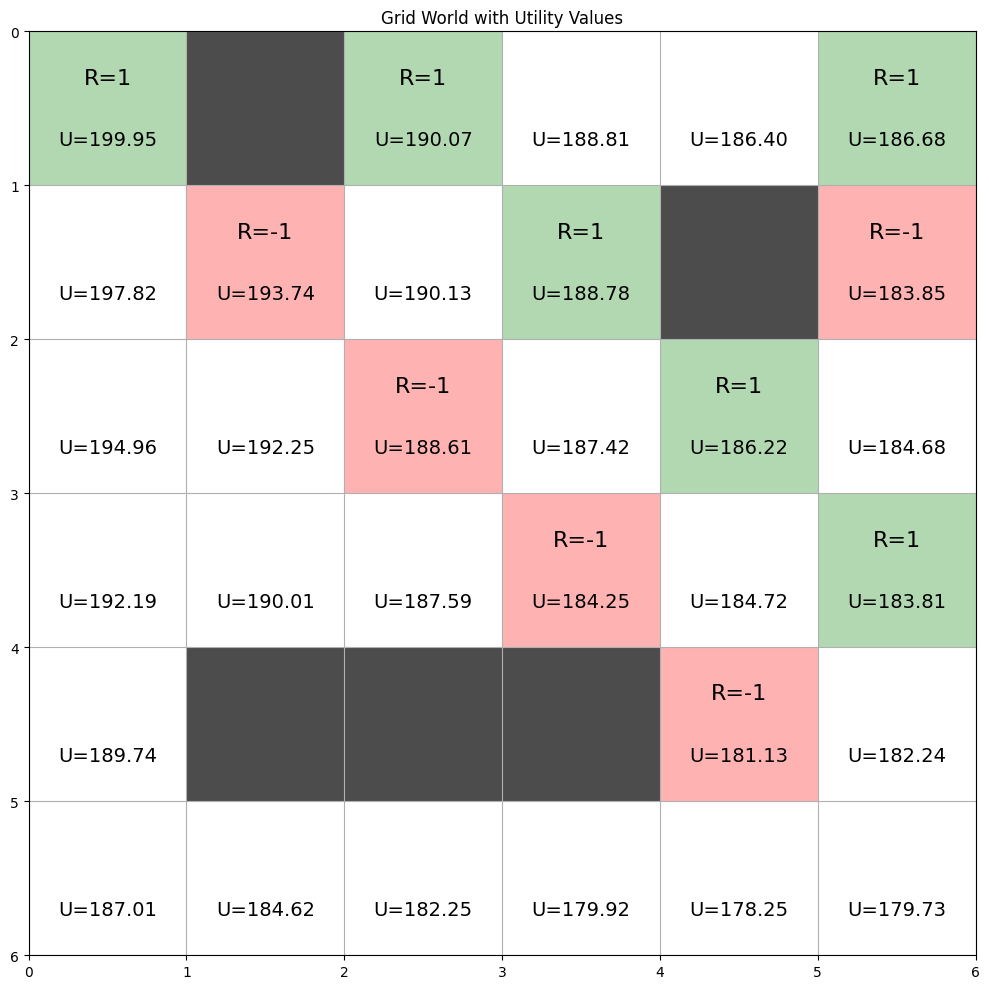


Policy Iteration Results:


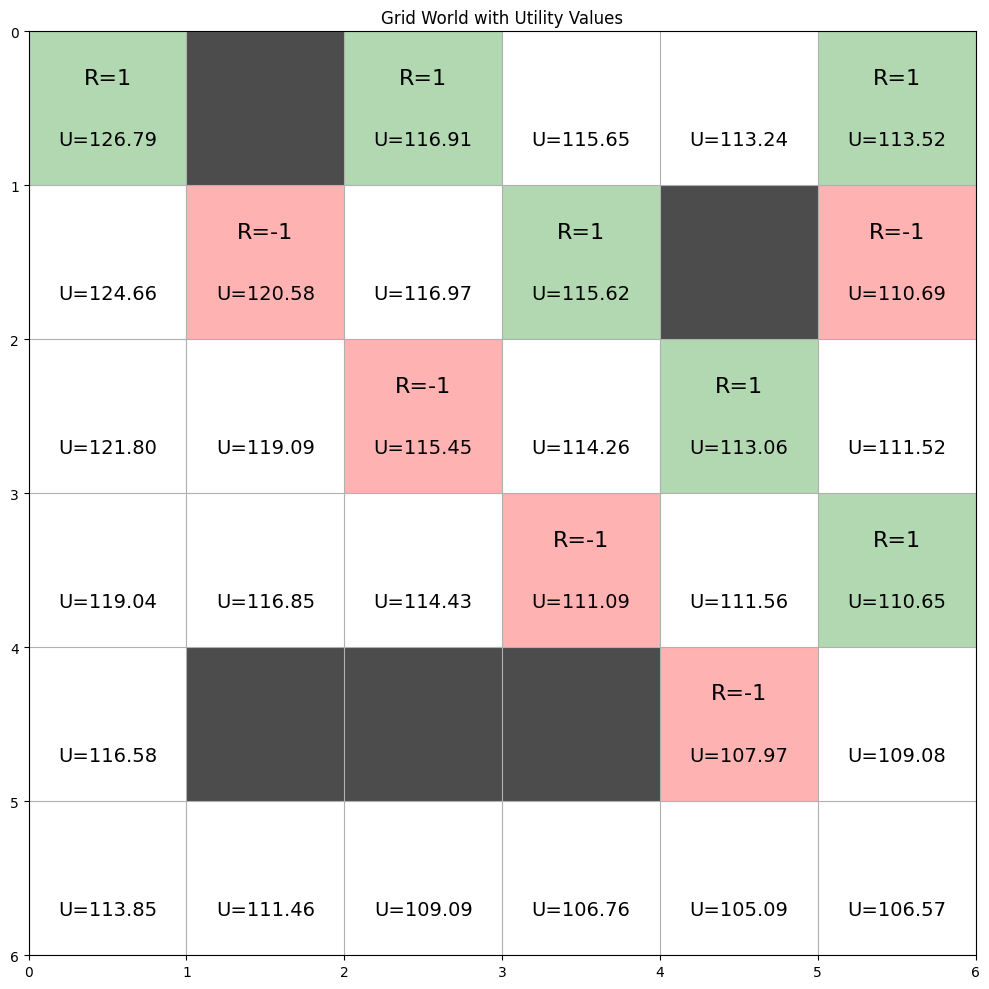


Value Iteration Utility Evolution:


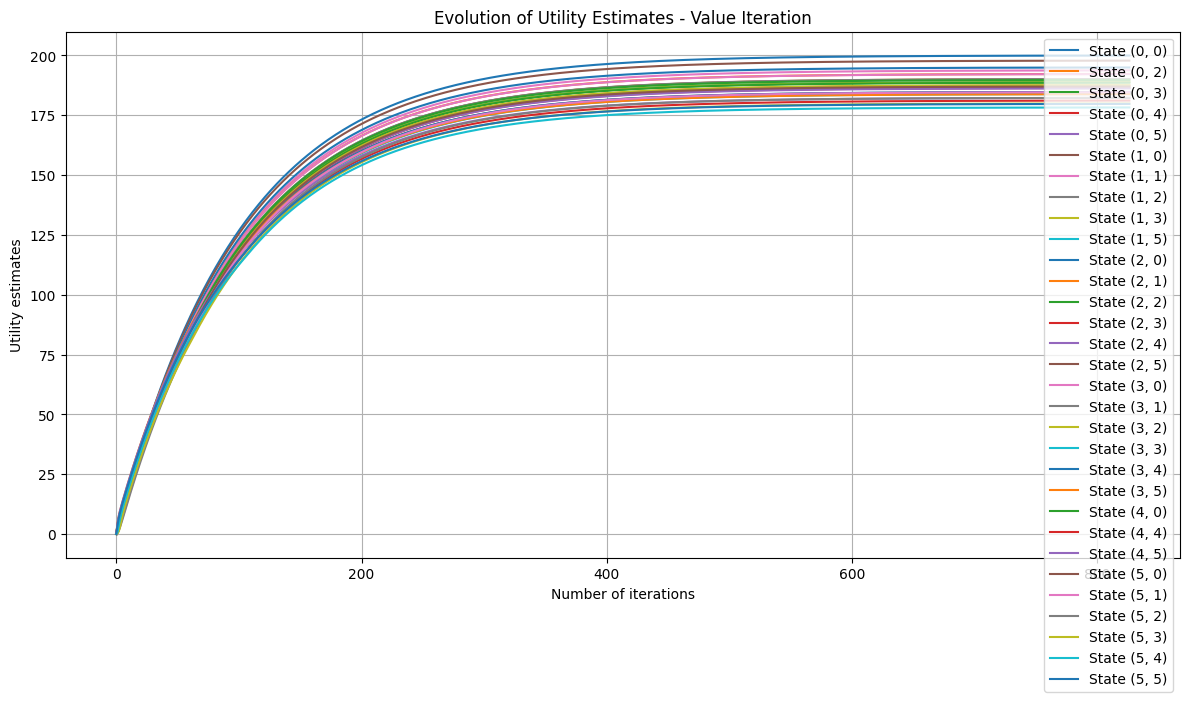


Policy Iteration Utility Evolution:


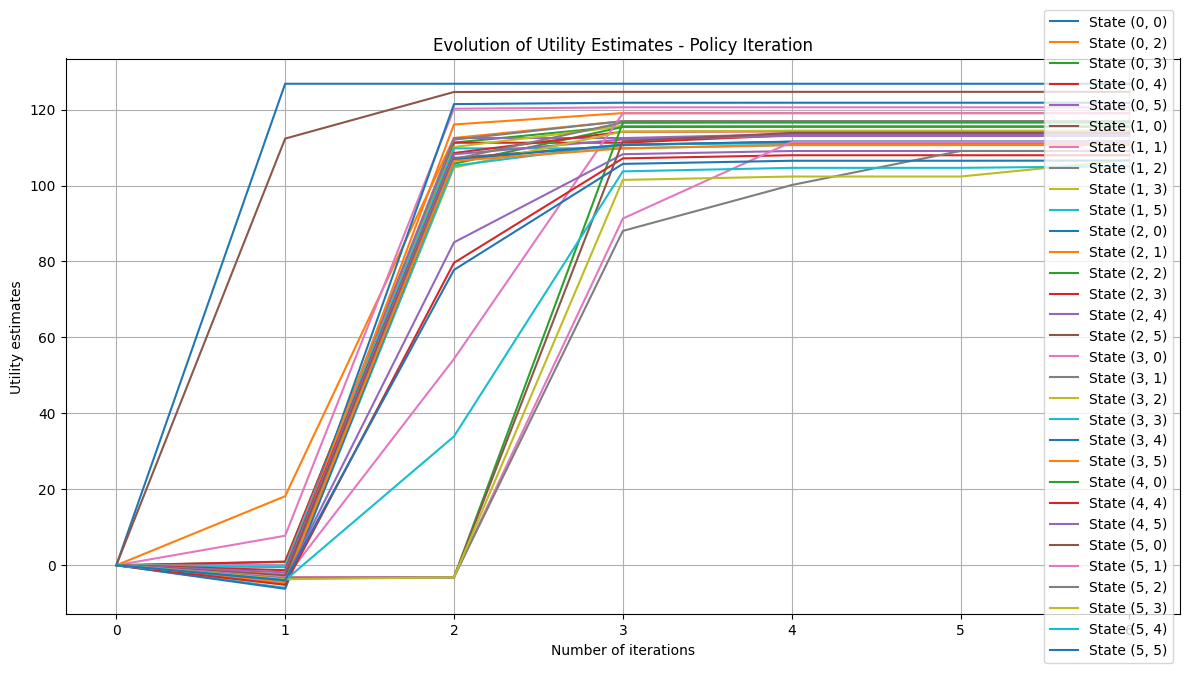

In [56]:
map1 = {
        "walls": [(0, 1), (1, 4), (4, 1), (4, 2), (4, 3)],
        "rewards": {
            (0, 0): 1, (0, 2): 1, (0, 5): 1, 
            (1, 1): -1, (1, 3): 1, (1, 5): -1,          
            (2, 2): -1, (2, 4): 1,                  
            (3, 3): -1, (3, 5): 1,           
            (4, 4): -1
        },
        "start_state": (3, 2),
    }

grid = Grid(walls=map1["walls"], start_state=map1["start_state"], rewards=map1["rewards"])
compare_algorithms(grid)

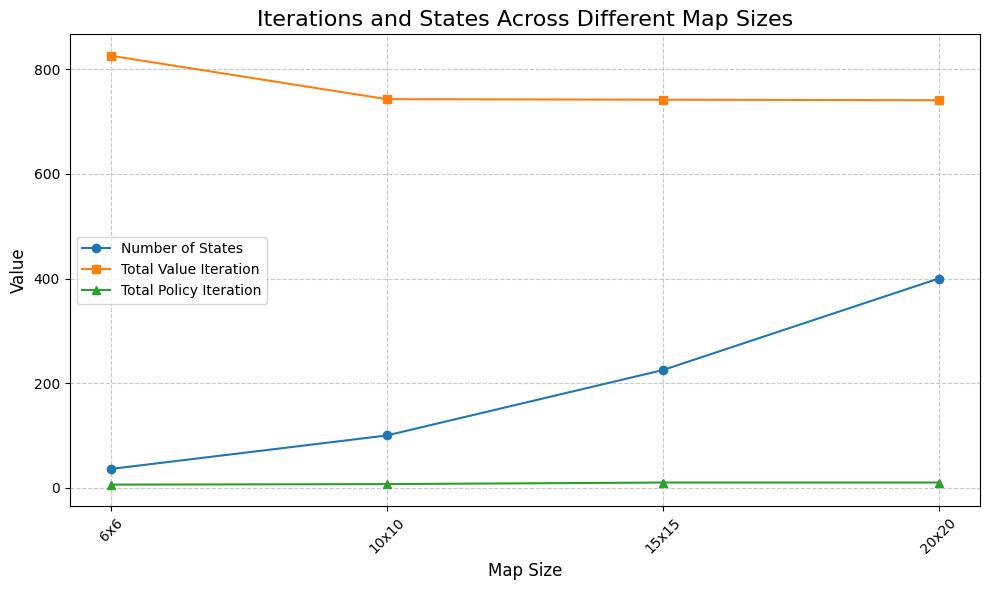

In [ ]:
import matplotlib.pyplot as plt

maps = ['6x6', '10x10', '15x15', '20x20']
number_of_states = [36, 100, 225, 400]
value_iteration = [826, 743, 742, 741]
policy_iteration = [6, 7, 10, 10]

plt.figure(figsize=(10, 6))
plt.plot(maps, number_of_states, marker='o', label='Number of States')
plt.plot(maps, value_iteration, marker='s', label='Total Value Iteration')
plt.plot(maps, policy_iteration, marker='^', label='Total Policy Iteration')

plt.title('Iterations and States Across Different Map Sizes', fontsize=16)
plt.xlabel('Map Size', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()